# Creating a Test System 

This is the 5 bus system from the text book of Glover et al. 

J. D. Glover, M. S. Sarma, and T. J. Overbye, Power System Analysis and Design, 5th ed. Stamford, CT: Cengage Learning, 2012.

https://al-roomi.org/component/content/article?id=76:5-bus-system-glover-s-book

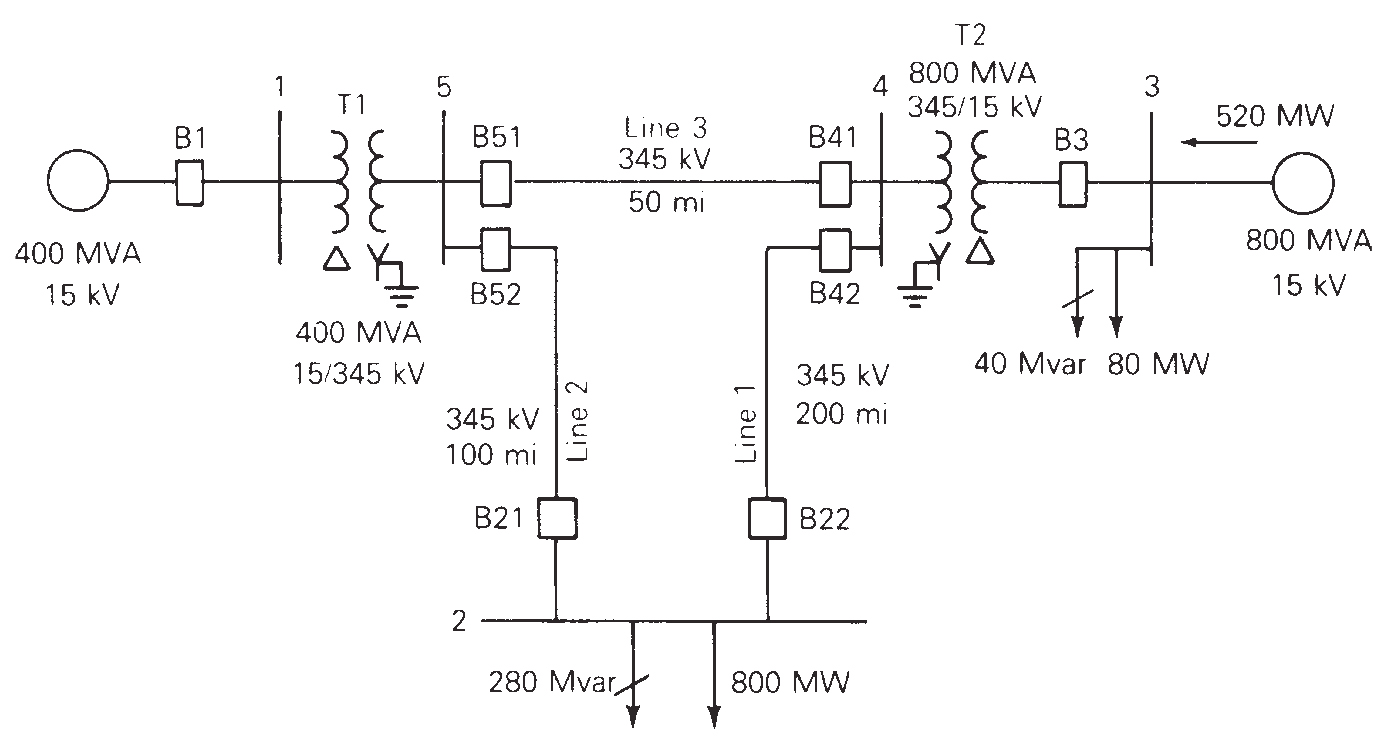



In [1]:
import pandas as pd
import pandapower as pp
import pandapower.plotting as plot
from numpy import pi, sqrt
import os
import matplotlib.pyplot as plt
from pandas import DataFrame

Building the system, buses and lines 

In [2]:
net = pp.create_empty_network(f_hz=60)

In [3]:
b1 = pp.create_bus(net, vn_kv=15, name="bus1", type="b")
b2 = pp.create_bus(net, vn_kv=345, name="bus2", type="b")
b3 = pp.create_bus(net, vn_kv=15, name="bus3", type="b")
b4 = pp.create_bus(net, vn_kv=345, name="bus4", type="b")
b5 = pp.create_bus(net, vn_kv=345, name="bus5", type="b")

In [4]:
pp.create_ext_grid(net, bus=b1, vm_pu=1, va_degree=0, name="Grid Connection")
pp.create_gen(net, b3, p_mw=520, max_q_mvar=400, min_q_mvar=-280, vm_pu=1.05, name="generator") 

0

In [5]:
pp.create_load(net, bus=b2, p_mw=800, q_mvar=280, name="Load")
pp.create_load(net, bus=b3, p_mw=80, q_mvar=40, name="Load")

1

### Covert the parameters of lines from per unit values to actual values

In [6]:
Sb=100
Zb=345**2/Sb

R24=0.009*Zb;  X24=0.1*Zb;  B24=1.72/Zb;  c24=B24/(2*pi*net.f_hz)*1e9
R25=0.0045*Zb;  X25=0.05*Zb;  B25=0.88/Zb;  c25=B25/(2*pi*net.f_hz)*1e9
R45=0.00225*Zb;  X45=0.025*Zb;  B45=0.44/Zb;  c45=B45/(2*pi*net.f_hz)*1e9
Ik=1200e6/(sqrt(3)*345e3)/1000

In [7]:
L24=pp.create_line_from_parameters(net, from_bus=b2, to_bus=b4, length_km=1, 
                               name="Line 2-4", r_ohm_per_km= R24, x_ohm_per_km=X24, 
                               c_nf_per_km=c24, max_i_ka=Ik)

L25=pp.create_line_from_parameters(net, from_bus=b2, to_bus=b5, length_km=1, 
                               name="Line 2-5", r_ohm_per_km= R25, x_ohm_per_km=X25, 
                               c_nf_per_km=c25, max_i_ka=Ik)

L45=pp.create_line_from_parameters(net, from_bus=b4, to_bus=b5, length_km=1, 
                               name="Line 4-5", r_ohm_per_km= R45, x_ohm_per_km=X45, 
                               c_nf_per_km=c45, max_i_ka=Ik)

### Covert the parameters of transformers from per unit values to per unit at each transformer ratings 

In [8]:
Sb=Sb;  Zb=Zb
# svma_tr15=400
# svma_tr34=800
svma_tr15=600
svma_tr34=1000

Ik_Tr15=600e6/(sqrt(3)*345e3)/1000
Ik_Tr34=1000e6/(sqrt(3)*345e3)/1000

Zb_Tr15=345**2/svma_tr15
Zb_Tr34=345**2/svma_tr34

R15=0.0015*Zb/Zb_Tr15
X15=0.02*Zb/Zb_Tr15
Z15=sqrt(R15**2+X15**2)

VKR15=R15*100
VK15=Z15*100

print('VKR15=',VKR15, 'VK15=',VK15)

R34=0.00075*Zb/Zb_Tr34
X34=0.01*Zb/Zb_Tr34
Z34=sqrt(R34**2+X34**2)

VKR34=R34*100
VK34=Z34*100

print('VKR34=',VKR34, 'VK34=',VK34)

VKR15= 0.8999999999999999 VK15= 12.033702672078947
VKR34= 0.75 VK34= 10.028085560065788


In [9]:
trafo15 = pp.create_transformer_from_parameters(net, lv_bus=b1, hv_bus=b5, name="Tr15", sn_mva=svma_tr15, 
max_loading_percent=Ik_Tr15, vn_hv_kv=345, vn_lv_kv=15, vkr_percent=VKR15, vk_percent=VK15, pfe_kw=1e-9, i0_percent=1e-9)

trafo34 = pp.create_transformer_from_parameters(net, lv_bus=b3, hv_bus=b4, name="Tr34", sn_mva=svma_tr34, 
max_loading_percent=Ik_Tr34, vn_hv_kv=345, vn_lv_kv=15, vkr_percent=VKR34, vk_percent=VK34, pfe_kw=1e-9, i0_percent=1e-9)

In [10]:
net

This pandapower network includes the following parameter tables:
   - bus (5 elements)
   - load (2 elements)
   - gen (1 element)
   - ext_grid (1 element)
   - line (3 elements)
   - trafo (2 elements)

In [11]:
net.gen

,name,bus,p_mw,vm_pu,sn_mva,min_q_mvar,max_q_mvar,scaling,slack,in_service,type,power_station_trafo
0,generator,2,520.0,1.05,NaN,-280.0,400.0,1.0,False,True,None,NaN


In [12]:
net.line

,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,g_us_per_km,max_i_ka,df,parallel,type,in_service
0,Line 2-4,None,1,3,1.0,10.712250,119.02500,3833.179334,0.0,2.008175,1.0,1,None,True
1,Line 2-5,None,1,4,1.0,5.356125,59.51250,1961.161520,0.0,2.008175,1.0,1,None,True
2,Line 4-5,None,3,4,1.0,2.678062,29.75625,980.580760,0.0,2.008175,1.0,1,None,True


In [13]:
net.load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type
0,Load,1,800.0,280.0,0.0,0.0,NaN,1.0,True,wye
1,Load,2,80.0,40.0,0.0,0.0,NaN,1.0,True,wye


In [14]:
net.trafo

,name,std_type,hv_bus,lv_bus,sn_mva,vn_hv_kv,vn_lv_kv,vk_percent,vkr_percent,pfe_kw,...,tap_step_percent,tap_step_degree,tap_pos,tap_phase_shifter,parallel,df,in_service,pt_percent,oltc,max_loading_percent
0,Tr15,None,4,0,600.0,345.0,15.0,12.033703,0.90,1.000000e-09,...,NaN,NaN,NaN,False,1,1.0,True,NaN,False,1.004087
1,Tr34,None,3,2,1000.0,345.0,15.0,10.028086,0.75,1.000000e-09,...,NaN,NaN,NaN,False,1,1.0,True,NaN,False,1.673479


In [15]:
# run power flow
pp.runpp(net)
# pp.runpp(net,enforce_q_lims=True)
# pp.runpp(net,algorithm='gs', max_iteration=7, tolerance_mva=1e-03)

In [16]:
net.res_ext_grid

,p_mw,q_mvar
0,394.838758,114.282901


In [17]:
net.res_bus 

,vm_pu,va_degree,p_mw,q_mvar
0,1.000000,0.000000,-394.838758,-114.282901
1,0.833768,-22.406418,800.000000,280.000000
2,1.050000,-0.597346,-440.000000,-297.479630
3,1.019302,-2.833974,0.000000,0.000000
4,0.974288,-4.547884,0.000000,0.000000


In [18]:
net.res_line

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent
0,-291.841143,-139.105361,303.682403,121.538371,11.841260,-17.566989,0.648900,0.537030,0.648900,0.833768,-22.406418,1.019302,-2.833974,32.312946
1,-508.158857,-140.894639,525.662074,263.020927,17.503217,122.126288,1.058419,1.009618,1.058419,0.833768,-22.406418,0.974288,-4.547884,52.705501
2,134.398589,150.354490,-133.357690,-182.529672,1.040900,-32.175182,0.331094,0.388283,0.388283,1.019302,-2.833974,0.974288,-4.547884,19.335143


In [19]:
net.res_trafo

,p_hv_mw,q_hv_mvar,p_lv_mw,q_lv_mvar,pl_mw,ql_mvar,i_hv_ka,i_lv_ka,vm_hv_pu,va_hv_degree,vm_lv_pu,va_lv_degree,loading_percent
0,-392.304384,-80.491255,394.838758,114.282901,2.534373,33.791645,0.687876,15.821140,0.974288,-4.547884,1.00,0.000000,68.507547
1,-438.080992,-271.892861,440.000000,297.479630,1.919008,25.586769,0.846502,19.469547,1.019302,-2.833974,1.05,-0.597346,50.583366


In [20]:
# net.res_bus.vm_pu.max()
viol_bus=net.res_bus[(net.res_bus['vm_pu']<0.95) | (net.res_bus['vm_pu']>1.05)]
display(viol_bus)
print("Violated Buses:", list(net.bus.name.iloc[viol_bus.index]))

,vm_pu,va_degree,p_mw,q_mvar
1,0.833768,-22.406418,800.0,280.0


Violated Buses: ['bus2']


In [21]:
loaded_lines=net.res_line[net.res_line['loading_percent']>50]
# display(loaded_lines)
df_nL=net.line.name[loaded_lines.index]                    
df_PL=net.res_line.loading_percent[loaded_lines.index]
pd.DataFrame({'Name': df_nL.values, 'Loading%': df_PL.values})

,Name,Loading%
0,Line 2-5,52.705501


The solution as in
https://al-roomi.org/power-flow/5-bus-systems/system-ii

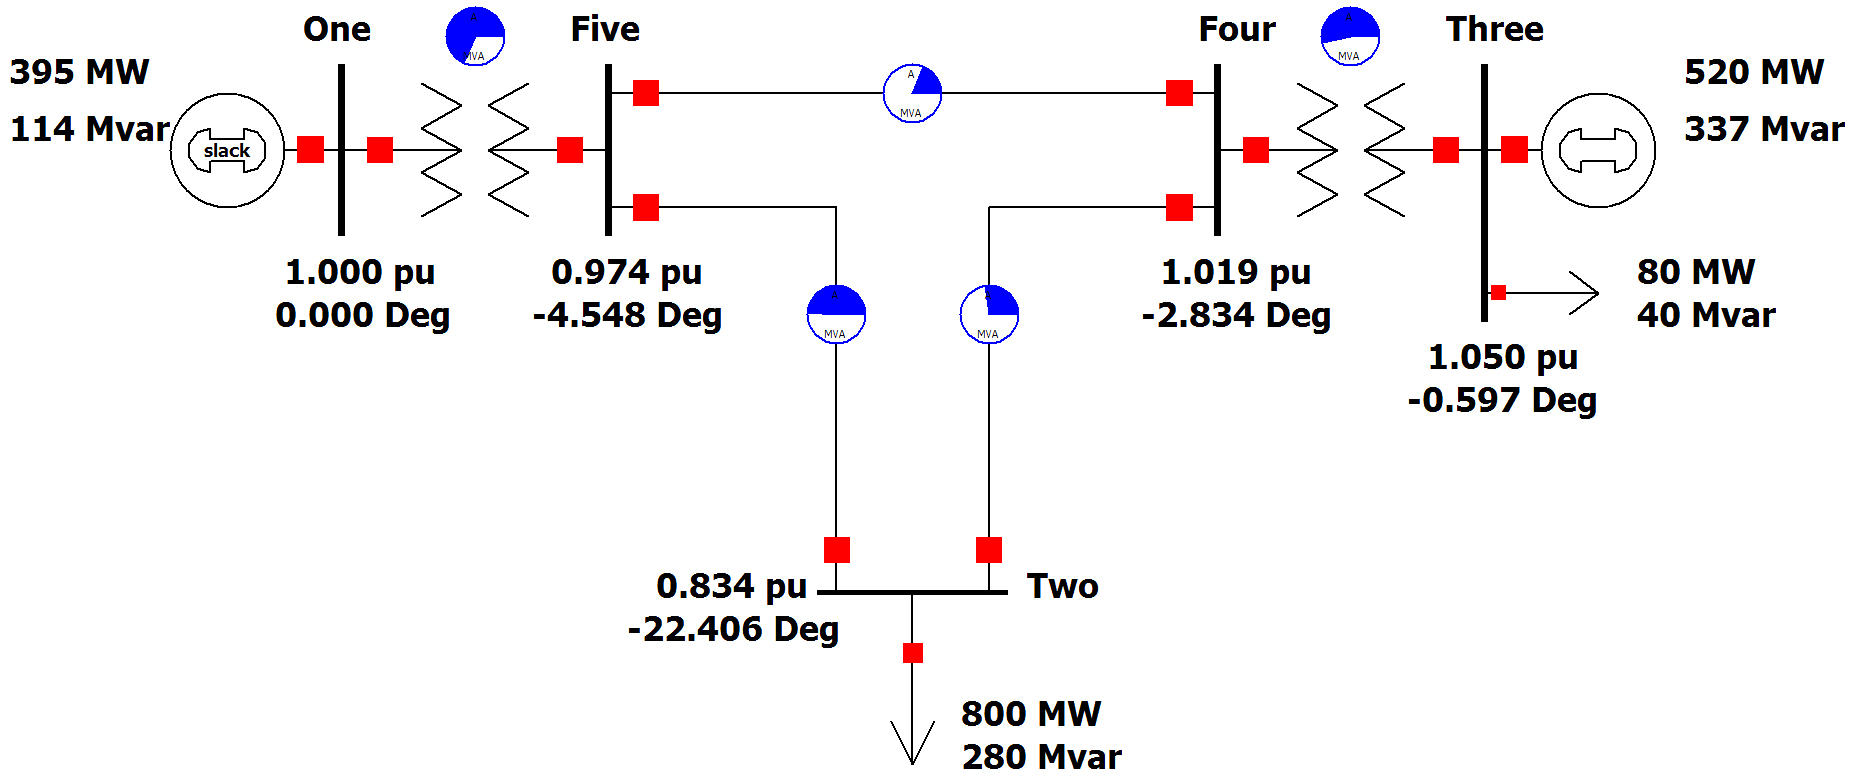

### Check out Ybus

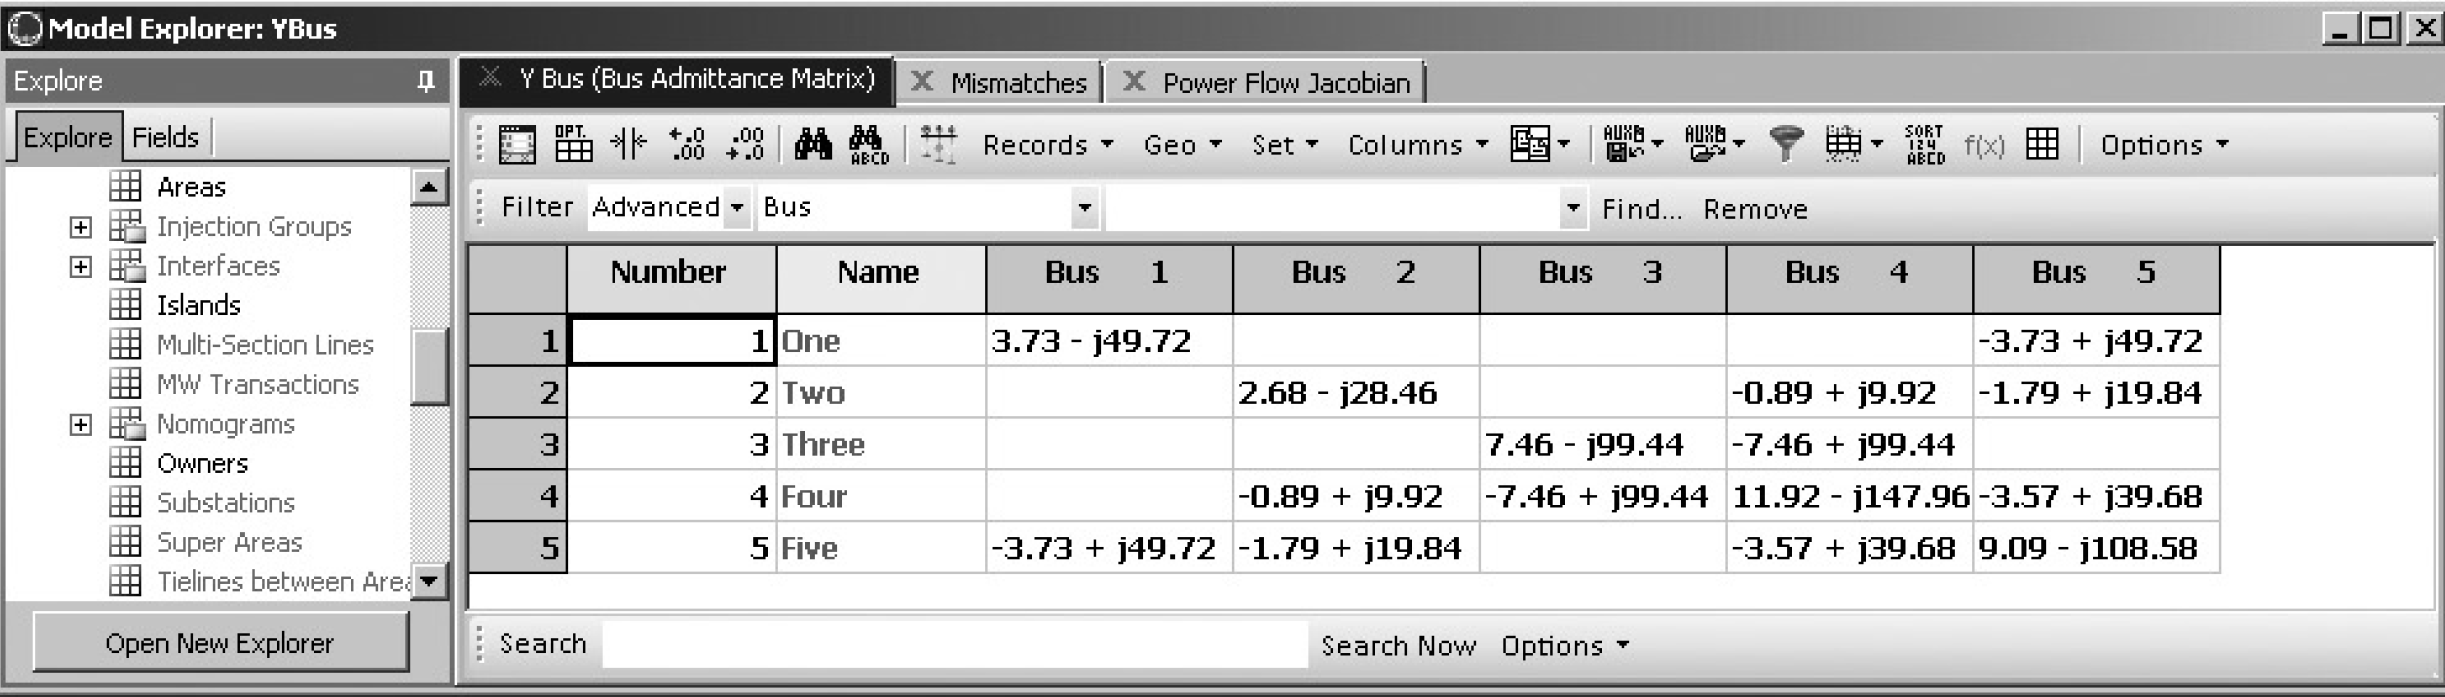

In [22]:
Ybs=(round(net['_ppc']['internal']['Ybus'],5))
print(Ybs)

  (0, 0)	(372.90242-4972.03232j)
  (0, 4)	(-372.90242+4972.03232j)
  (1, 1)	(267.83057-2845.89525j)
  (1, 3)	(-89.27686+991.96508j)
  (1, 4)	(-178.55371+1983.93017j)
  (2, 2)	(745.80485-9944.06464j)
  (2, 3)	(-745.80485+9944.06464j)
  (3, 1)	(-89.27686+991.96508j)
  (3, 2)	(-745.80485+9944.06464j)
  (3, 3)	(1192.18914-14795.89005j)
  (3, 4)	(-357.10743+3967.86033j)
  (4, 0)	(-372.90242+4972.03232j)
  (4, 1)	(-178.55371+1983.93017j)
  (4, 3)	(-357.10743+3967.86033j)
  (4, 4)	(908.56357-10857.82282j)


### The effect of adding shunt capacitor banks

Check out the effect of adding 200Mvar shunt capcitor banks at Bus 2

In [23]:
pp.create_shunt(net, bus=1, q_mvar=-200, p_mw=0, vn_kv=345, name='C_b2')

0

In [24]:
net.shunt

,bus,name,q_mvar,p_mw,vn_kv,step,max_step,in_service
0,1,C_b2,-200.0,0.0,345.0,1,1,True


In [25]:
pp.runpp(net)

In [26]:
# net.res_bus.vm_pu.max()
viol_bus=net.res_bus[(net.res_bus['vm_pu']<0.95) | (net.res_bus['vm_pu']>1.05)]
display(viol_bus)
print("Violated Buses:", list(net.bus.name.iloc[viol_bus.index]))

,vm_pu,va_degree,p_mw,q_mvar


Violated Buses: []


In [27]:
loaded_lines=net.res_line[net.res_line['loading_percent']>50]
# display(loaded_lines)
df_nL=net.line.name[loaded_lines.index]                    
df_PL=net.res_line.loading_percent[loaded_lines.index]
pd.DataFrame({'Name': df_nL.values, 'Loading%': df_PL.values})

,Name,Loading%


In [32]:
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.000000,0.000000,-385.374577,36.495220
1,0.959106,-19.779426,800.000000,96.023277
2,1.050000,-0.415384,-440.000000,-120.455624
3,1.036198,-2.685494,0.000000,0.000000
4,1.004522,-4.431830,0.000000,0.000000


In [29]:
net.res_line

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent
0,-292.458076,-82.825856,300.827719,4.373094,8.369644,-78.452762,0.530360,0.485894,0.530360,0.959106,-19.779426,1.036198,-2.685494,26.410045
1,-507.541924,-13.197421,520.179859,68.745203,12.637935,55.547783,0.885875,0.874126,0.885875,0.959106,-19.779426,1.004522,-4.431830,44.113448
2,137.756569,97.206379,-137.052964,-135.209517,0.703605,-38.003137,0.272292,0.320733,0.320733,1.036198,-2.685494,1.004522,-4.431830,15.971366


In [30]:
net.res_trafo

,p_hv_mw,q_hv_mvar,p_lv_mw,q_lv_mvar,pl_mw,ql_mvar,i_hv_ka,i_lv_ka,vm_hv_pu,va_hv_degree,vm_lv_pu,va_lv_degree,loading_percent
0,-383.126895,66.464313,385.374577,-36.495220,2.247682,29.969093,0.647802,14.899439,1.004522,-4.431830,1.00,0.000000,64.516463
1,-438.584289,-101.579474,440.000000,120.455624,1.415711,18.876150,0.727071,16.722639,1.036198,-2.685494,1.05,-0.415384,43.446692


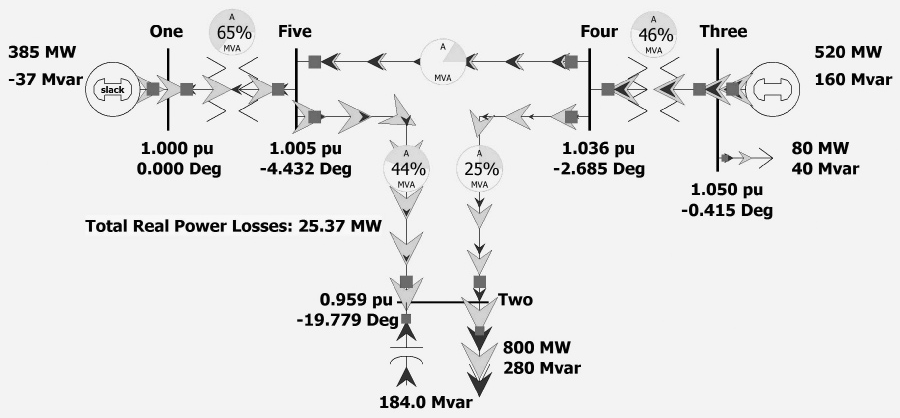